In [1]:
import pickle
import boris_extraction as boris
import multirecording_spikeanalysis as spike
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import sem
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import matplotlib.patches as mpatches
from itertools import combinations
from collections import defaultdict
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import matplotlib.ticker as ticker



def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))
phase2_collection = unpickle_this('phase2collection.pkl')

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titleweight'] = 'bold'


c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Functions

In [2]:

                                   
def __PCA_for_decoding_minus_pc1__(equalize, pre_window, post_window, no_PCs, events, counter_event=None):
        full_PCA_matrix, t_df, key, coefficients, explained_variance_ratios = phase2_analysis.PCA_matrix_generation(equalize, pre_window, post_window, events = None)
        recordings = full_PCA_matrix.columns.to_list()
        recording_list = np.unique(recordings)
        coefficients = coefficients[:, 1:no_PCs]
        recording_indices = get_indices(recordings)
        decoder_data1 = {}
        all_events = events
        if counter_event is not None:
            for event in counter_event:
                if event not in all_events:
                    all_events.append(event)
        #decoder data dict: events for keys, values is a list of len(events)
        #each element in the list is the transformed matrix
        for recording in recording_list:
            #iterate through recordings
            start = recording_indices[recording][0]
            stop = recording_indices[recording][1]
            #trim weight matrix for only those neurons in the current recording
            subset_coeff = coefficients[start:stop+1, :]
            recording_instance = phase2_analysis.ephyscollection.get_by_name(recording)
            for event in all_events:
                #grab all event firing rates for current event in current recording
                event_firing_rates = phase2_analysis.__get_event_firing_rates__(recording_instance, event,
                                                                equalize, pre_window, post_window)
                for trial in range(len(event_firing_rates)):
                    #iterate through each event
                    trial_data = np.transpose(event_firing_rates[trial])
                    #transpoe event firing rates from neurons x timebins to timebins x neurons
                    transformed_trial = np.dot(trial_data, subset_coeff)
                    #transform each trial with original weight matrix
                    #T (timebins x pcs) = D (timebins x neurons). W (pcs x neurons) 
                    if event in decoder_data1.keys():
                        #append transformed matrix to decoder_data1 dict
                        decoder_data1[event].append(transformed_trial)
                    else: 
                        decoder_data1[event] = []
                        decoder_data1[event].append(transformed_trial)
        return decoder_data1


def get_indices(repeated_items_list):
    """
    Takes in an indexed key or a list of repeated items, 
    creates a list of indices that correspond to each unique item.

    Args (1):
        repeated_items_list: list, list of repeated items

    Returns:
        item_indices: list of tuples, where the first element
            is the first index of an item, and the second
            element is the last index of that item
    """
    is_first = True
    item_indices = {}
    for i in range(len(repeated_items_list)):
        if is_first:
            current_item = repeated_items_list[i]
            start_index = 0
            is_first = False
        else:
            if repeated_items_list[i] == current_item:
                end_index = i
                if i == (len(repeated_items_list)-1):
                    item_indices[current_item] = [start_index, end_index]
            else:
                item_indices[current_item] = [start_index, end_index]
                start_index = i
                current_item = repeated_items_list[i]
    return item_indices

def __PCA_for_decoding__(equalize, pre_window, post_window, no_PCs, events, counter_events = None):
        full_PCA_matrix, t_df, key, coefficients, explained_variance_ratios = phase2_analysis.PCA_matrix_generation(equalize, pre_window, post_window, events = events)
        recordings = full_PCA_matrix.columns.to_list()
        recording_list = np.unique(recordings)
        coefficients = coefficients[:, :no_PCs]
        recording_indices = get_indices(recordings)
        decoder_data = {}
        if counter_events is not None:
            for event in counter_events:
                if event not in events:
                    events.append(event)
        #decoder data dict: events for keys, values is a list of len(events)
        #each element in the list is the transformed matrix
        for recording in recording_list:
            #iterate through recording
            start = recording_indices[recording][0]
            stop = recording_indices[recording][1]
            #trim weight matrix for only those neurons in the current recording
            subset_coeff = coefficients[start:stop+1, :]
            recording_instance = phase2_analysis.ephyscollection.get_by_name(recording)
            for event in events:
                #grab all event firing rates for current event in current recording
                event_firing_rates = phase2_analysis.__get_event_firing_rates__(recording_instance, event,
                                                                equalize, pre_window, post_window)
                for trial in range(len(event_firing_rates)):
                    #iterate through each event
                    trial_data = np.transpose(event_firing_rates[trial])
                    #transpoe event firing rates from neurons x timebins to timebins x neurons
                    transformed_trial = np.dot(trial_data, subset_coeff)
                    #transform each trial with original weight matrix
                    #T (timebins x pcs) = D (timebins x neurons). W (pcs x neurons) 
                    if event in decoder_data.keys():
                        #append transformed matrix to decoder_data1 dict
                        decoder_data[event].append(transformed_trial)
                    else: 
                        decoder_data[event] = []
                        decoder_data[event].append(transformed_trial)
        return decoder_data



def cross_trial_decoder(equalize, pre_window, post_window, num_fold, num_shuffle, no_PCs, same_event, event1, event2, plot = True):
    decoder_data1 = __PCA_for_decoding__(equalize, pre_window, post_window, no_PCs, events = [same_event, event1], counter_events = [event2])
    decoder_data2 = __PCA_for_decoding__(equalize, pre_window, post_window, no_PCs, events = [same_event, event2], counter_events = [event1])
    ex_trial_matrix = decoder_data1[same_event][0]
    T = ex_trial_matrix.shape[0]
    auc = {}
    diff_events = [event1, event2]
    decoders = [decoder_data1, decoder_data2]
    for i in [0,1]:  
        data_neg_train = []
        data_neg_test = []
        data_pos = []
        decoder_data = decoders[i]  
        for trial in decoder_data[same_event]:
            data_pos.append(trial)
        for trial in decoder_data[diff_events[i]]:
            data_neg_train.append(trial)
        if i == 0:
            for trial in decoder_data[diff_events[1]]:
                data_neg_test.append(trial)
        else:
            for trial in decoder_data[diff_events[0]]:
                data_neg_test.append(trial)
        data_pos= np.stack(data_pos, axis=2)
        data_neg_train = np.stack(data_neg_train, axis=2)
        data_neg_test = np.stack(data_neg_test, axis=2)
        num_pos = data_pos.shape[2]
        num_neg_train = data_neg_train.shape[2]
        num_neg_test = data_neg_test.shape[2]
        data_pos = data_pos[:, :, np.random.permutation(num_pos)]
        data_neg_train = data_neg_train[:, :, np.random.permutation(num_neg_train)]
        data_neg_test = data_neg_test[:, :, np.random.permutation(num_neg_test)]
        event = diff_events[i]
        auc[event] = {'glm': [], 'rf': [], 'glm_shuffle': [], 'rf_shuffle': []}
        for fold in range(num_fold):
            auc_glm = []
            auc_rf = []
            auc_glm_shuffle = []
            auc_rf_shuffle = []
            pos_fold = num_pos // num_fold
            neg_fold_train = num_neg_train // num_fold
            neg_fold_test = num_neg_test // num_fold
            data_test = np.concatenate((data_pos[:, :, fold * pos_fold:(fold + 1) * pos_fold],
                                        data_neg_test[:, :, fold * neg_fold_test:(fold + 1) * neg_fold_test]), axis=2)
            label_test = np.concatenate((np.ones((fold + 1) * pos_fold - fold * pos_fold),
                                        np.zeros((fold + 1) * neg_fold_test - fold * neg_fold_test)))
            data_train = np.concatenate((
                data_pos[:, :, np.setdiff1d(np.arange(num_pos), 
                np.arange(fold * pos_fold, (fold + 1) * pos_fold))],
                data_neg_train[:, :, np.setdiff1d(np.arange(num_neg_train), 
                np.arange(fold * neg_fold_train, (fold + 1) * neg_fold_train))]),
                axis=2)
            label_train = np.concatenate((np.ones(num_pos - (fold + 1) * pos_fold + fold * pos_fold),
                                        np.zeros(num_neg_train - (fold + 1) * neg_fold_train + fold * neg_fold_train)))
            for timebin in range(T):
                model_glm = LogisticRegression(class_weight='balanced') 
                model_glm.fit(data_train[timebin, :, :].T, label_train)
                pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
                auc_glm.append(roc_auc_score(label_test, pred_glm[:, 1]))
                
                model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_estimators=50, random_state=0)
                model_rf.fit(data_train[timebin, :, :].T, label_train)
                pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
                auc_rf.append(roc_auc_score(label_test, pred_rf[:, 1]))
            auc[event]['glm'].append(auc_glm)
            auc[event]['rf'].append(auc_rf)
            for shuffle in range(num_shuffle):
                temp_glm_shuffle = []
                temp_rf_shuffle = []
                label_train = np.random.permutation(label_train)
                for timebin in range(T):
                    model_glm = LogisticRegression(class_weight='balanced')
                    model_glm.fit(data_train[timebin, :, :].T, label_train)
                    pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
                    temp_glm_shuffle.append(roc_auc_score(label_test, pred_glm[:, 1]))

                    model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_estimators=50, random_state=0)
                    model_rf.fit(data_train[timebin, :, :].T, label_train)
                    pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
                    temp_rf_shuffle.append(roc_auc_score(label_test, pred_rf[:, 1]))
                auc_glm_shuffle.append(temp_glm_shuffle)
                auc_rf_shuffle.append(temp_rf_shuffle)
            auc[event]['glm_shuffle'].append(auc_glm_shuffle)
            auc[event]['rf_shuffle'].append(auc_rf_shuffle)
    if plot:
        __plot_auc__(auc, equalize, pre_window)
    return auc

def trial_decoder_AvB_BvC(equalize, pre_window, post_window, num_fold, num_shuffle, no_PCs, training_events, test_events, plot = True):
    #ugh fuck okay so this gonna take the 4/5 of positive training data, and make it the 1/5 neg data if two events are the same type
    decoder_data = __PCA_for_decoding__(equalize, pre_window, post_window, no_PCs, events = training_events, counter_events = test_events)
    ex_trial_matrix = decoder_data[training_events[0]][0]
    T = ex_trial_matrix.shape[0]
    all_events = list(set(training_events + test_events))
    auc = {}  
    data_A = []
    data_B = []
    data_C = []
    i = 0
    for event in all_events:
        for trial in decoder_data[event]:
            if i == 0: 
                data_A.append(trial)
            if i == 1:
                data_B.append(trial)
            if i == 2:
                data_C.append(trial)
        i+=1
    data_A= np.stack(data_A, axis=2)
    data_B = np.stack(data_B, axis=2)
    data_C = np.stack(data_C, axis=2)
    num_A = data_A.shape[2]
    num_B = data_B.shape[2]
    num_C = data_C.shape[2]
    data_A = data_A[:, :, np.random.permutation(num_A)]
    data_B = data_B[:, :, np.random.permutation(num_B)]
    data_C = data_C[:, :, np.random.permutation(num_C)]
    auc = {'glm': [], 'rf': [], 'glm_shuffle': [], 'rf_shuffle': []}
    for fold in range(num_fold):
        auc_glm = []
        auc_rf = []
        auc_glm_shuffle = []
        auc_rf_shuffle = []
        A_fold = num_A // num_fold
        B_fold = num_B // num_fold
        C_fold = num_C // num_fold
        data_test = np.concatenate((data_C[:, :, fold * C_fold:(fold + 1) * C_fold],
                                    data_B[:, :, fold * B_fold:(fold + 1) * B_fold]), axis=2)
        #here B is pos and c is neg
        label_test = np.concatenate((np.zeros((fold + 1) * C_fold - fold * C_fold),
                                    np.ones((fold + 1) * B_fold - fold * B_fold)))
        #so here i want A to be pos and b to neg  
        data_train = np.concatenate((
            data_B[:, :, np.setdiff1d(np.arange(num_B), 
            np.arange(fold * B_fold, (fold + 1) * B_fold))],
            data_A[:, :, np.setdiff1d(np.arange(num_A), 
            np.arange(fold * A_fold, (fold + 1) * A_fold))]),
            axis=2)
        label_train = np.concatenate((np.zeros(num_B - (fold + 1) * B_fold + fold * B_fold),
                                    np.ones(num_A - (fold + 1) * A_fold + fold * A_fold)))
        for timebin in range(T):
            model_glm = LogisticRegression(class_weight='balanced') 
            model_glm.fit(data_train[timebin, :, :].T, label_train)
            pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
            auc_glm.append(roc_auc_score(label_test, pred_glm[:, 1]))
            
            model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_estimators=50, random_state=0)
            model_rf.fit(data_train[timebin, :, :].T, label_train)
            pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
            auc_rf.append(roc_auc_score(label_test, pred_rf[:, 1]))
        auc['glm'].append(auc_glm)
        auc['rf'].append(auc_rf)
        for shuffle in range(num_shuffle):
            temp_glm_shuffle = []
            temp_rf_shuffle = []
            label_train = np.random.permutation(label_train)
            for timebin in range(T):
                model_glm = LogisticRegression(class_weight='balanced')
                model_glm.fit(data_train[timebin, :, :].T, label_train)
                pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
                temp_glm_shuffle.append(roc_auc_score(label_test, pred_glm[:, 1]))

                model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_estimators=50, random_state=0)
                model_rf.fit(data_train[timebin, :, :].T, label_train)
                pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
                temp_rf_shuffle.append(roc_auc_score(label_test, pred_rf[:, 1]))
            auc_glm_shuffle.append(temp_glm_shuffle)
            auc_rf_shuffle.append(temp_rf_shuffle)
        auc['glm_shuffle'].append(auc_glm_shuffle)
        auc['rf_shuffle'].append(auc_rf_shuffle)
    if plot:
        __plot_auc_1__(auc, equalize, pre_window)
    return auc

def __plot_auc_1__(auc_dict, equalize, pre_window):
    avg_auc = {}
    no_plots = len(auc_dict.keys())
    height_fig = math.ceil(no_plots/2)
    plt.figure(figsize=(12,4*height_fig))
    glm_avg = np.mean(auc_dict['glm'], axis = 0)
    glm_sem = sem(auc_dict['glm'], axis = 0)
    x =np.linspace(-pre_window, equalize, len(glm_avg))
    rf_avg = np.mean(auc_dict['rf'], axis = 0)
    rf_sem = sem(auc_dict['rf'], axis = 0)
    glm_shuffle_avg = np.mean(np.mean(auc_dict['glm_shuffle'], axis = 1), axis = 0)
    glm_shuffle_sem = sem(np.mean(auc_dict['glm_shuffle'], axis = 1), axis = 0)
    rf_shuffle_avg = np.mean(np.mean(auc_dict['rf_shuffle'], axis = 1), axis = 0)
    rf_shuffle_sem = sem(np.mean(auc_dict['rf_shuffle'], axis = 1), axis = 0)
    plt.plot(x, glm_avg, label ='glm')
    plt.fill_between(x, glm_avg-glm_sem, glm_avg+glm_sem, alpha = 0.2)
    plt.plot(x, rf_avg, label =  'rf')
    plt.fill_between(x, rf_avg-rf_sem, rf_avg+rf_sem, alpha = 0.2)
    plt.plot(x, glm_shuffle_avg, label = 'glm shuffle')
    plt.fill_between(x, glm_shuffle_avg-glm_shuffle_sem, glm_shuffle_avg+glm_shuffle_sem, alpha = 0.2)
    plt.plot(x, rf_shuffle_avg, label = 'rf shuffle')
    plt.fill_between(x, rf_shuffle_avg-rf_shuffle_sem, rf_shuffle_avg+rf_shuffle_sem, alpha = 0.2)
    plt.ylim(.25, 1)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.legend(bbox_to_anchor=(1,1))
    plt.title('Decoder Accuracy')
    plt.show()
            
def __plot_auc__(auc_dict, equalize, pre_window):
    avg_auc = {}
    no_plots = len(auc_dict.keys())
    height_fig = math.ceil(no_plots/2)
    i = 1
    plt.figure(figsize=(12,4*height_fig))
    for key in auc_dict.keys():
        glm_avg = np.mean(auc_dict[key]['glm'], axis = 0)
        glm_sem = sem(auc_dict[key]['glm'], axis = 0)
        x =np.linspace(-pre_window, equalize, len(glm_avg))
        rf_avg = np.mean(auc_dict[key]['rf'], axis = 0)
        rf_sem = sem(auc_dict[key]['rf'], axis = 0)
        glm_shuffle_avg = np.mean(np.mean(auc_dict[key]['glm_shuffle'], axis = 1), axis = 0)
        glm_shuffle_sem = sem(np.mean(auc_dict[key]['glm_shuffle'], axis = 1), axis = 0)
        rf_shuffle_avg = np.mean(np.mean(auc_dict[key]['rf_shuffle'], axis = 1), axis = 0)
        rf_shuffle_sem = sem(np.mean(auc_dict[key]['rf_shuffle'], axis = 1), axis = 0)
        avg_auc[key] = [glm_avg, rf_avg, glm_shuffle_avg, rf_shuffle_avg]
        plt.subplot(height_fig,2,i)
        plt.plot(x, glm_avg, label ='glm')
        plt.fill_between(x, glm_avg-glm_sem, glm_avg+glm_sem, alpha = 0.2)
        plt.plot(x, rf_avg, label =  'rf')
        plt.fill_between(x, rf_avg-rf_sem, rf_avg+rf_sem, alpha = 0.2)
        plt.plot(x, glm_shuffle_avg, label = 'glm shuffle')
        plt.fill_between(x, glm_shuffle_avg-glm_shuffle_sem, glm_shuffle_avg+glm_shuffle_sem, alpha = 0.2)
        plt.plot(x, rf_shuffle_avg, label = 'rf shuffle')
        plt.fill_between(x, rf_shuffle_avg-rf_shuffle_sem, rf_shuffle_avg+rf_shuffle_sem, alpha = 0.2)
        plt.title(f'Trained for {key}')
        plt.ylim(.4, 1)
        plt.axvline(x=0, color='k', linestyle='--')
        if i == 2:
            plt.legend(bbox_to_anchor=(1,1))
        i += 1
    plt.suptitle('Decoder Accuracy')
    plt.show()

    
def collapsed_auc_list(auc, t1, t2, timebin, pre_window):
    collapsed_auc_dict = {}
    glm = {}
    glm_shuffle = {}
    rf = {}
    rf_shuffle = {}
    t1 = int((t1 + pre_window) * 1000 / timebin)
    t2 = int((t2 + pre_window) * 1000 / timebin)
    for key in auc[0].keys():
        try:
            glm_across_time = np.array(auc[0][key]['glm'])
            glm_trimmed = glm_across_time[:, t1:t2]
        # glm across time = fold x timebins 
            glm[key] = np.mean(glm_trimmed, axis =1)
        except KeyError:
            pass
        try:
            rf_across_time = np.array(auc[0][key]['rf'])
            rf_trimmed = rf_across_time[:, t1:t2]
            rf[key] =  np.mean(rf_trimmed, axis =1)
        except KeyError:
            pass
        glm_shuffle_temp = []
        rf_shuffle_temp = []
        for i in range(5):
            try:
                glm_shuffle_across_time = np.array(auc[0][key]['glm_shuffle'][i])
                glm_shuffle_trimmed = glm_shuffle_across_time[:, t1:t2]
                glm_shuffle_temp.append(np.mean(glm_shuffle_trimmed, axis = 1))
            except KeyError:
                pass
            try:
                rf_shuffle_across_time = np.array(auc[0][key]['rf_shuffle'][i])
                rf_shuffle_trimmed = rf_shuffle_across_time[:, t1:t2]
                rf_shuffle_temp.append(np.mean(rf_shuffle_trimmed, axis = 1))
            except KeyError:
                pass
        try:    
            glm_shuffle[key] = np.mean(np.array(glm_shuffle_temp), axis = 1)
        except:
            pass
        rf_shuffle[key] = np.mean(np.array(rf_shuffle_temp), axis = 1)
    if not glm:
        collapsed_auc_dict = {'Random Forest\nClassifier':rf,'Shuffled':rf_shuffle}
    else: 
        collapsed_auc_dict = {'Generalized\nLinear Model':glm,'Shuffled ':glm_shuffle,
                    'Random Forest\nClassifier':rf,'Shuffled':rf_shuffle}
    return collapsed_auc_dict 

def make_training_data(group_a, group_b, group_c, events, test_event, equalize, pre_window, post_window, no_PCs, num_fold, num_shuffle, plot=True):
    decoder_data = __PCA_for_decoding_tagged_(equalize, pre_window, post_window, no_PCs, events)
    ex_trial_matrix = decoder_data[group_a[0]][events[0]][0]
    T = ex_trial_matrix.shape[0]
    auc = {}  
    groups = ['group_a', 'group_b', 'group_c']
    group_dict = {'group_a': group_a, 'group_b': group_b, 'group_c':group_c}
    for group in groups:
        data_neg_test = []
        data_pos_test = []
        data_neg_train = []
        data_pos_train = []
        for recording in group_dict[group]:
            data = decoder_data[recording]
            for event in events:
                if event == test_event:
                    for trial in data[event]:
                        data_pos_test.append(trial)
                else:
                    for trial in data[event]:
                        data_neg_test.append(trial)
        data_pos_test = np.stack(data_pos_test, axis=2)
        data_neg_test = np.stack(data_neg_test, axis=2)
        num_pos_test = data_pos_test.shape[2]
        num_neg_test = data_neg_test.shape[2]
        for train_group in np.setdiff1d(groups, group):
            for recording in group_dict[train_group]:
                data = decoder_data[recording]
                for event in events:
                    if event == test_event:
                        for trial in data[event]:
                            data_pos_train.append(trial)
                    else:
                        for trial in data[event]:
                            data_neg_train.append(trial)
        data_pos_train = np.stack(data_pos_train, axis=2)
        data_neg_train = np.stack(data_neg_train, axis=2)
        num_pos_train = data_pos_train.shape[2]
        num_neg_train = data_neg_train.shape[2]
        print('training set:', num_neg_train, num_pos_train, num_neg_train/num_pos_train)
        print('testing set:', num_neg_test, num_pos_test, num_neg_test/num_pos_test)
        data_pos_train = data_pos_train[:, :, np.random.permutation(num_pos_train)]
        data_pos_test = data_pos_test[:, :, np.random.permutation(num_pos_test)]
        data_neg_train = data_neg_train[:, :, np.random.permutation(num_neg_train)]
        data_neg_test = data_neg_test[:, :, np.random.permutation(num_neg_test)]
        auc[group] = {'glm': [], 'rf': [], 'glm_shuffle': [], 'rf_shuffle': []}
        for fold in range(num_fold):
            auc_glm = []
            auc_rf = []
            auc_glm_shuffle = []
            auc_rf_shuffle = []
            pos_fold_test = num_pos_test // num_fold
            pos_fold_train = num_pos_train //num_fold
            neg_fold_train = num_neg_train // num_fold
            neg_fold_test = num_neg_test // num_fold
            data_test = np.concatenate((data_pos_test[:, :, fold * pos_fold_test:(fold + 1) * pos_fold_test],
                                        data_neg_test[:, :, fold * neg_fold_test:(fold + 1) * neg_fold_test]), axis=2)
            #here B is pos and c is neg
            label_test = np.concatenate((np.ones((fold + 1) * pos_fold_test - fold * pos_fold_test),
                                        np.zeros((fold + 1) * neg_fold_test - fold * neg_fold_test)))
            #so here i want A to be pos and b to neg  
            data_train = np.concatenate((
                data_pos_train[:, :, np.setdiff1d(np.arange(num_pos_train), 
                np.arange(fold * pos_fold_train, (fold + 1) * pos_fold_train))],
                data_neg_train[:, :, np.setdiff1d(np.arange(num_neg_train), 
                np.arange(fold * neg_fold_train, (fold + 1) * neg_fold_train))]),
                axis=2)
            label_train = np.concatenate((np.ones(num_pos_train - (fold + 1) * pos_fold_train + fold * pos_fold_train),
                                        np.zeros(num_neg_train - (fold + 1) * neg_fold_train + fold * neg_fold_train)))
            for timebin in range(T):
                model_glm = LogisticRegression(class_weight='balanced')
                model_glm.fit(data_train[timebin, :, :].T, label_train)
                pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
                auc_glm.append(roc_auc_score(label_test, pred_glm[:, 1]))
                
                model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_estimators=50, random_state=0)
                model_rf.fit(data_train[timebin, :, :].T, label_train)
                pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
                auc_rf.append(roc_auc_score(label_test, pred_rf[:, 1]))
            auc[group]['glm'].append(auc_glm)
            auc[group]['rf'].append(auc_rf)
            for shuffle in range(num_shuffle):
                temp_glm_shuffle = []
                temp_rf_shuffle = []
                label_train = np.random.permutation(label_train)
                for timebin in range(T):
                    model_glm = LogisticRegression(class_weight='balanced')
                    model_glm.fit(data_train[timebin, :, :].T, label_train)
                    pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
                    temp_glm_shuffle.append(roc_auc_score(label_test, pred_glm[:, 1]))

                    model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_estimators=50, random_state=0)
                    model_rf.fit(data_train[timebin, :, :].T, label_train)
                    pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
                    temp_rf_shuffle.append(roc_auc_score(label_test, pred_rf[:, 1]))
                auc_glm_shuffle.append(temp_glm_shuffle)
                auc_rf_shuffle.append(temp_rf_shuffle)
            auc[group]['glm_shuffle'].append(auc_glm_shuffle)
            auc[group]['rf_shuffle'].append(auc_rf_shuffle)
    if plot:
        __plot_auc__(auc, equalize, pre_window)
    return auc
            



def collapsed_auc_dict(auc, t1, t2, timebin, pre_window):
    collapsed_auc_dict = {}
    glm = {}
    glm_shuffle = {}
    rf = {}
    rf_shuffle = {}
    t1 = int((t1 + pre_window) * 1000 / timebin)
    t2 = int((t2 + pre_window) * 1000 / timebin)
    for key in auc.keys():
        try:
            glm_across_time = np.array(auc[key]['glm'])
            glm_trimmed = glm_across_time[:, t1:t2]
            # glm across time = fold x timebins 
            glm[key] = np.mean(glm_trimmed, axis =1)
        except KeyError:
            pass
        rf_across_time = np.array(auc[key]['rf'])
        rf_trimmed = rf_across_time[:, t1:t2]
        rf[key] =  np.mean(rf_trimmed, axis =1)
        glm_shuffle_temp = []
        rf_shuffle_temp = []
        for i in range(5):
            # glm_shuffle_across_time = np.array(auc[key]['glm_shuffle'][i])
            # glm_shuffle_trimmed = glm_shuffle_across_time[:, t1:t2]
            # glm_shuffle_temp.append(np.mean(glm_shuffle_trimmed, axis = 1))
            rf_shuffle_across_time = np.array(auc[key]['rf_shuffle'][i])
            rf_shuffle_trimmed = rf_shuffle_across_time[:, t1:t2]
            rf_shuffle_temp.append(np.mean(rf_shuffle_trimmed, axis = 1))
        # glm_shuffle[key] = np.mean(np.array(glm_shuffle_temp), axis = 1)
        rf_shuffle[key] = np.mean(np.array(rf_shuffle_temp), axis = 1)
    collapsed_auc_dict = {
        # 'Generalized\nLinear Model':glm,'Shuffled ':glm_shuffle,
                    'Random\nForest':rf,'Shuffled':rf_shuffle}
    return collapsed_auc_dict 



def across_pcs_auc(auc_dict, t1, t2, timebin, pre_window):
    pc_dict = {}
    for pc in auc_dict.keys():
        pc_dict[pc] = collapsed_auc_dict(auc_dict[pc], t1, t2, timebin, pre_window)
    return pc_dict

def __PCA_for_decoding_tagged_(equalize, pre_window, post_window, no_PCs, events, counter_events = None):
        full_PCA_matrix, t_df, key, coefficients, explained_variance_ratios = phase2_analysis.PCA_matrix_generation(equalize, pre_window, post_window, events = events)
        print(explained_variance_ratios[0:10])
        recordings = full_PCA_matrix.columns.to_list()
        recording_list = np.unique(recordings)
        coefficients = coefficients[:, :no_PCs]
        recording_indices = get_indices(recordings)
        decoder_data = []
        if counter_events is not None:
            for event in counter_events:
                if event not in events:
                    events.append(event)
        #decoder data dict: events for keys, values is a list of len(events)
        #each element in the list is the transformed matrix
        for recording in recording_list:
            #iterate through recording
            start = recording_indices[recording][0]
            stop = recording_indices[recording][1]
            #trim weight matrix for only those neurons in the current recording
            subset_coeff = coefficients[start:stop+1, :]
            recording_instance = phase2_analysis.ephyscollection.get_by_name(recording)
            recording_data = {}
            for event in events:
                #grab all event firing rates for current event in current recording
                event_firing_rates = phase2_analysis.__get_event_firing_rates__(recording_instance, event,
                                                                equalize, pre_window, post_window)
                for trial in range(len(event_firing_rates)):
                    #iterate through each event
                    trial_data = np.transpose(event_firing_rates[trial])
                    #transpoe event firing rates from neurons x timebins to timebins x neurons
                    transformed_trial = np.dot(trial_data, subset_coeff)
                    #transform each trial with original weight matrix
                    #T (timebins x pcs) = D (timebins x neurons). W (pcs x neurons) 

                    decoder_data.append([transformed_trial, event, recording_instance.order_dict[event]])
        return decoder_data 
 

 
def decode_id_w_time_labels(equalize, pre_window, post_window, num_fold, num_shuffle, no_PCs, events, plot = True):
    decoder_data = __PCA_for_decoding_tagged_(equalize, pre_window, post_window, no_PCs, events = events)
    #decoder data = list(timebins x pcs)
    T = (equalize + pre_window + post_window) * 1000 / phase2_analysis.timebin
    auc = {}
    prob = {}
    for event in events:
        data_neg = []
        data_pos = []
        pos_time_labels = []
        neg_time_labels = []
        neg_events = np.setdiff1d(events, event)
        for trial in decoder_data:
            if trial[1] == event:
                data_pos.append(trial[0])
                pos_time_labels.append(trial[2])
            if trial[1] in neg_events:
                data_neg.append(trial[0])
                neg_time_labels.append(trial[2])
        data_pos = np.stack(data_pos, axis=2)
        data_neg = np.stack(data_neg, axis=2)
        neg_time_labels = np.array(neg_time_labels)
        pos_time_labels = np.array(pos_time_labels)
        num_pos = data_pos.shape[2]
        num_neg = data_neg.shape[2]
        shuffle_pos = np.random.permutation(num_pos)
        shuffle_neg = np.random.permutation(num_neg)
        new_pos_labels = pos_time_labels[shuffle_pos]
        new_neg_labels = neg_time_labels[shuffle_neg]
        data_pos = data_pos[:, :, shuffle_pos]
        data_neg = data_neg[:, :, shuffle_neg]
        auc[event] = {'glm': [], 'rf': [],
                        'glm_shuffle': [], 'rf_shuffle': []}
        prob[event] = {'glm': [], 'rf': [], 
                        'glm_shuffle': [], 'rf_shuffle': [], 'time labels': [], 'id labels': []}
        for fold in range(num_fold):
            auc_glm = []
            auc_rf = []
            auc_glm_shuffle = []
            auc_rf_shuffle = []
            prob_glm = []
            prob_rf = []
            prob_glm_shuffle = []
            prob_rf_shuffle = []
            pos_fold = num_pos // num_fold
            neg_fold = num_neg // num_fold
            data_test = np.concatenate((data_pos[:, :, fold * pos_fold:(fold + 1) * pos_fold],
                                        data_neg[:, :, fold * neg_fold:(fold + 1) * neg_fold]), axis=2)
            label_test = np.concatenate((np.ones((fold + 1) * pos_fold - fold * pos_fold),
                                        np.zeros((fold + 1) * neg_fold - fold * neg_fold)))
            label_time = np.concatenate(
                [new_pos_labels[fold * pos_fold:(fold + 1) * pos_fold],
                new_neg_labels[fold * neg_fold:(fold + 1) * neg_fold]])
            data_train = np.concatenate((
                data_pos[:, :, np.setdiff1d(np.arange(num_pos), 
                np.arange(fold * pos_fold, (fold + 1) * pos_fold))],
                data_neg[:, :, np.setdiff1d(np.arange(num_neg), 
                np.arange(fold * neg_fold, (fold + 1) * neg_fold))]),
                axis=2)
            label_train = np.concatenate((np.ones(num_pos - (fold + 1) * pos_fold + fold * pos_fold),
                                        np.zeros(num_neg - (fold + 1) * neg_fold + fold * neg_fold)))
            for timebin in range(int(T)):
                model_glm = LogisticRegression(class_weight='balanced')
                model_glm.fit(data_train[timebin, :, :].T, label_train)
                pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
                prob_glm.append(pred_glm[:,1])
                auc_glm.append(roc_auc_score(label_test, pred_glm[:, 1]))
                auc_test = roc_auc_score(label_test, pred_glm[:, 1])
        
                model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_estimators=50, random_state=0)
                model_rf.fit(data_train[timebin, :, :].T, label_train)
                pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
                prob_rf.append(pred_rf[:,1])
                auc_rf.append(roc_auc_score(label_test, pred_rf[:, 1]))
            auc[event]['glm'].append(auc_glm)
            auc[event]['rf'].append(auc_rf)
            prob[event]['glm'].append(prob_glm)
            prob[event]['rf'].append(prob_rf)
            prob[event]['time labels'].append(label_time)
            prob[event]['id labels'].append(label_test)
            for shuffle in range(num_shuffle):
                temp_glm_shuffle = []
                temp_rf_shuffle = []
                temp_prob_glm_shuffle = []
                temp_prob_rf_shuffle = [] 
                label_train = np.random.permutation(label_train)
                for timebin in range(int(T)):
                    model_glm = LogisticRegression(class_weight='balanced')
                    model_glm.fit(data_train[timebin, :, :].T, label_train)
                    pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
                    temp_prob_glm_shuffle.append(pred_glm[:,1])
                    temp_glm_shuffle.append(roc_auc_score(label_test, pred_glm[:, 1]))

                    model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_estimators=50, random_state=0)
                    model_rf.fit(data_train[timebin, :, :].T, label_train)
                    pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
                    temp_prob_rf_shuffle.append(pred_rf[:,1])
                    temp_rf_shuffle.append(roc_auc_score(label_test, pred_rf[:, 1]))
                auc_glm_shuffle.append(temp_glm_shuffle)
                auc_rf_shuffle.append(temp_rf_shuffle)
                prob_glm_shuffle.append(temp_prob_glm_shuffle)
                prob_rf_shuffle.append(temp_prob_rf_shuffle)
            auc[event]['glm_shuffle'].append(auc_glm_shuffle)
            auc[event]['rf_shuffle'].append(auc_rf_shuffle)
            prob[event]['glm_shuffle'].append(prob_glm_shuffle)
            prob[event]['rf_shuffle'].append(prob_rf_shuffle)
    if plot:
        phase2_analysis.__plot_auc__(auc, equalize, pre_window)
    for events in prob.values():
        for model, data in events.items():
            data = np.array(data)
            events[model] = data
    for events in auc.values():
        for model, data in events.items():
            events[model] = np.array(data)
    return [auc, prob]
    
def trial_decoder_avg_timebin(equalize, pre_window, post_window, num_fold, num_shuffle, no_PCs, events, plot = True):
        event_average_firing_rates = defaultdict(list)
        for recording in phase2_collection.collection.values():
            for event in events:
                firing_rates = np.array(phase2_analysis.__get_event_firing_rates__(recording,
                                                                            event,
                                                                        equalize,
                                                                        pre_window,
                                                                        post_window))

                average_firing_rates = np.mean(firing_rates, axis = 2)
                for trial in average_firing_rates:
                    event_average_firing_rates[event].append(trial)
        # for event in event_average_firing_rates.keys():
        #     event_average_firing_rates[event] = np.array(event_average_firing_rates[event])
        #decoder data = list(timebins x pcs)
        # ex_trial_matrix = decoder_data[events[0]][0]
        # T = ex_trial_matrix.shape[0]
        auc = {}
        prob = {}
        for event in events:
            data_neg = []
            data_pos = []
            for trial in event_average_firing_rates[event]:
                data_pos.append(trial)
            for neg_event in np.setdiff1d(events, event):
                for trial in event_average_firing_rates[neg_event]:
                    data_neg.append(trial)
            data_pos = np.stack(data_pos, axis=1)
            print(data_pos.shape)
            data_neg = np.stack(data_neg, axis=1)
            print(data_neg.shape)
            num_pos = data_pos.shape[1]
            num_neg = data_neg.shape[1]
            data_pos = data_pos[:, :, np.random.permutation(num_pos)]
            data_neg = data_neg[:, :, np.random.permutation(num_neg)]
        #     auc[event] = {'glm': [], 'rf': [], 'svm': [],
        #                   'glm_shuffle': [], 'rf_shuffle': [], 'svm_shuffle': []}
        #     prob[event] = {'glm': [], 'rf': [], 
        #                    'glm_shuffle': [], 'rf_shuffle': [], 'svm_shuffle': []}
        #     for fold in range(num_fold):
        #         auc_glm = []
        #         auc_rf = []
        #         auc_glm_shuffle = []
        #         auc_rf_shuffle = []
        #         prob_glm = []
        #         prob_rf = []
        #         prob_glm_shuffle = []
        #         prob_rf_shuffle = []
        #         pos_fold = num_pos // num_fold
        #         neg_fold = num_neg // num_fold
        #         data_test = np.concatenate((data_pos[:, :, fold * pos_fold:(fold + 1) * pos_fold],
        #                                     data_neg[:, :, fold * neg_fold:(fold + 1) * neg_fold]), axis=2)
        #         label_test = np.concatenate((np.ones((fold + 1) * pos_fold - fold * pos_fold),
        #                                     np.zeros((fold + 1) * neg_fold - fold * neg_fold)))
        #         data_train = np.concatenate((
        #             data_pos[:, :, np.setdiff1d(np.arange(num_pos), 
        #             np.arange(fold * pos_fold, (fold + 1) * pos_fold))],
        #             data_neg[:, :, np.setdiff1d(np.arange(num_neg), 
        #             np.arange(fold * neg_fold, (fold + 1) * neg_fold))]),
        #             axis=2)
        #         label_train = np.concatenate((np.ones(num_pos - (fold + 1) * pos_fold + fold * pos_fold),
        #                                     np.zeros(num_neg - (fold + 1) * neg_fold + fold * neg_fold)))
        #         for timebin in range(T):
        #             model_glm = LogisticRegression(class_weight='balanced')
        #             model_glm.fit(data_train[timebin, :, :].T, label_train)
        #             pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
        #             prob_glm.append(pred_glm)
        #             auc_glm.append(roc_auc_score(label_test, pred_glm[:, 1]))
                 
        #             model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_estimators=50, random_state=0)
        #             model_rf.fit(data_train[timebin, :, :].T, label_train)
        #             pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
        #             prob_rf.append(pred_rf)
        #             auc_rf.append(roc_auc_score(label_test, pred_rf[:, 1]))
        #         auc[event]['glm'].append(auc_glm)
        #         auc[event]['rf'].append(auc_rf)
        #         prob[event]['glm'].append(prob_glm)
        #         prob[event]['rf'].append(prob_rf)
        #         for shuffle in range(num_shuffle):
        #             temp_glm_shuffle = []
        #             temp_rf_shuffle = []
        #             temp_prob_glm_shuffle = []
        #             temp_prob_rf_shuffle = [] 
        #             label_train = np.random.permutation(label_train)
        #             for timebin in range(T):
        #                 model_glm = LogisticRegression(class_weight='balanced')
        #                 model_glm.fit(data_train[timebin, :, :].T, label_train)
        #                 pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
        #                 temp_prob_glm_shuffle.append(pred_glm)
        #                 temp_glm_shuffle.append(roc_auc_score(label_test, pred_glm[:, 1]))

        #                 model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_estimators=50, random_state=0)
        #                 model_rf.fit(data_train[timebin, :, :].T, label_train)
        #                 pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
        #                 temp_prob_rf_shuffle.append(pred_rf)
        #                 temp_rf_shuffle.append(roc_auc_score(label_test, pred_rf[:, 1]))
        #             auc_glm_shuffle.append(temp_glm_shuffle)
        #             auc_rf_shuffle.append(temp_rf_shuffle)
        #             prob_glm_shuffle.append(temp_prob_glm_shuffle)
        #             prob_rf_shuffle.append(temp_prob_rf_shuffle)
        #         auc[event]['glm_shuffle'].append(auc_glm_shuffle)
        #         auc[event]['rf_shuffle'].append(auc_rf_shuffle)
        #         prob[event]['glm_shuffle'].append(prob_glm_shuffle)
        #         prob[event]['rf_shuffle'].append(prob_rf_shuffle)
        # if plot:
        #     self.__plot_auc__(auc, equalize, pre_window)
        # return [auc, prob]


In [3]:
# event_avg_fr = trial_decoder_avg_timebin(equalize = 3, pre_window = 1, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= 12, events = ['acquisition', 'novel', 'cagemate', 'recall'])
# len(event_avg_fr['acquisition'][10])

## Across PCS

### Decoder Calls

In [4]:
# all_3_larger_timebins = {}
# for pc in range(1,9):
#         all_3_larger_timebins[pc] = phase2_analysis.trial_decoder(equalize = 5, pre_window = 5, post_window = 0, num_fold=5, num_shuffle=5, no_PCs= pc, events = ['novel', 'cagemate', 'recall'])

### Plotting

In [5]:
# all_3_larger_timebins.keys()
# all_3_larger_timebins[1][0].keys()
# pickle_this(all_3_larger_timebins, 'three_agents_acrossPCs.pkl')
# pickle_this(all_4_larger_timebins, 'four_agents_acrossPCs.pkl')
# agents_three = across_pcs_auc(all_3_larger_timebins, 0, 3, 100, 5)

In [6]:

# plt.figure(figsize=(11,4))
# linestyle = ['-', '--','-', '--']
# i = 0
# subplots = [1,1,2,2]
# alpha = 0.1
# for model in agents_three[1].keys():
#     plt.subplot(1,2,subplots[i])
#     novel_avg = []
#     novel_sem = []
#     cagemate_avg = []
#     cagemate_sem = []
#     familiar_avg = []
#     familiar_sem = []
#     for pc in agents_three.keys():
#         novel_avg.append(np.mean(agents_three[pc][model]['novel'], axis = 0))
#         novel_sem.append(sem(agents_three[pc][model]['novel']))
#         cagemate_avg.append(np.mean(agents_three[pc][model]['cagemate'], axis = 0))
#         cagemate_sem.append(sem(agents_three[pc][model]['cagemate']))
#         familiar_avg.append(np.mean(agents_three[pc][model]['recall'], axis = 0))
#         familiar_sem.append(sem(agents_three[pc][model]['recall']))
#     x = list(agents_three.keys())
#     plt.plot(x, novel_avg, label ='novel', color=hex_2_rgb('#15616F'), linestyle = linestyle[i])
#     plt.fill_between(x, np.array(novel_avg)-np.array(novel_sem), np.array(novel_avg)+np.array(novel_sem),color=hex_2_rgb('#15616F'), alpha= alpha)
#     plt.plot(x, familiar_avg, label = 'familiar', color = (1.0, 0.6862745098039216, 0.0), linestyle = linestyle[i])
#     plt.fill_between(x, np.array(familiar_avg)-np.array(familiar_sem), np.array(familiar_avg)+np.array(familiar_sem), color = (1.0, 0.6862745098039216, 0.0), alpha = alpha)
#     plt.plot(x, cagemate_avg, label = 'cagemate', color=hex_2_rgb('#792910'), linestyle = linestyle[i])
#     plt.fill_between(x, np.array(cagemate_avg)-cagemate_sem, np.array(cagemate_avg)+np.array(cagemate_sem),color=hex_2_rgb('#792910'), alpha = alpha)
#     plt.ylim(0.3, 1)
#     plt.xlim(1,8)
#     plt.xticks(fontsize=14)
#     plt.yticks(fontsize=14)
#     plt.xlabel('PCs', fontsize=16)
#     plt.ylabel('Area Under the Curve Score', fontsize=16)
#     plt.axvline(x=4, color='k', linestyle='--', label = '>99% of variance')
#     plt.axvline(x=2, color='k', linestyle='--', label  = '>95% of variance')
#     plt.text(4.1,.95,'>99% of variance')
#     plt.text(2.15,.9,'>95% of variance')
#     if subplots[i] == 1:
#         plt.title('General Linearized Model', fontsize = 18)
#     else:
#         plt.title('Random Forest Classifier', fontsize = 18)
#     plt.gca().spines['top'].set_visible(False)
#     plt.gca().spines['right'].set_visible(False)
#     i +=1
# plt.suptitle('Principal components vs Decoder Accuracy', fontsize = 20, font = 'Arial', y = 1.1)
# plt.show()



In [7]:
# collpased_pc_dict = across_pcs_auc(all_4_larger_timebins, 0, 3, 100, 5)
# plt.figure(figsize=(12,4))
# linestyle = ['-', '--','-', '--']
# i = 0
# subplots = [1,1,2,2]
# for model in collpased_pc_dict[1].keys():
#     plt.subplot(1,2,subplots[i])
#     novel_avg = []
#     novel_sem = []
#     cagemate_avg = []
#     cagemate_sem = []
#     familiar_avg = []
#     familiar_sem = []
#     acquisition_avg = []
#     acquisition_sem = []
#     for pc in collpased_pc_dict.keys():
#         novel_avg.append(np.mean(collpased_pc_dict[pc][model]['novel'], axis = 0))
#         novel_sem.append(sem(collpased_pc_dict[pc][model]['novel']))
#         cagemate_avg.append(np.mean(collpased_pc_dict[pc][model]['cagemate'], axis = 0))
#         cagemate_sem.append(sem(collpased_pc_dict[pc][model]['cagemate']))
#         familiar_avg.append(np.mean(collpased_pc_dict[pc][model]['recall'], axis = 0))
#         familiar_sem.append(sem(collpased_pc_dict[pc][model]['recall']))
#         acquisition_avg.append(np.mean(collpased_pc_dict[pc][model]['acquisition'], axis = 0))
#         acquisition_sem.append(sem(collpased_pc_dict[pc][model]['acquisition']))
#     x = list(collpased_pc_dict.keys())
#     plt.plot(x, novel_avg, label ='novel', color=hex_2_rgb('#15616F'), linestyle = linestyle[i])
#     plt.fill_between(x, np.array(novel_avg)-np.array(novel_sem), np.array(novel_avg)+np.array(novel_sem),color=hex_2_rgb('#15616F'), alpha= alpha)
#     plt.plot(x, familiar_avg, label = 'familiar', color = (1.0, 0.6862745098039216, 0.0), linestyle = linestyle[i])
#     plt.fill_between(x, np.array(familiar_avg)-np.array(familiar_sem), np.array(familiar_avg)+np.array(familiar_sem), color = (1.0, 0.6862745098039216, 0.0), alpha = alpha)
#     plt.plot(x, cagemate_avg, label = 'cagemate', color=hex_2_rgb('#792910'), linestyle = linestyle[i])
#     plt.fill_between(x, np.array(cagemate_avg)-cagemate_sem, np.array(cagemate_avg)+np.array(cagemate_sem),color=hex_2_rgb('#792910'), alpha = alpha)
#     plt.plot(x, acquisition_avg, label = 'acquisition', color=hex_2_rgb('#001424'), linestyle = linestyle[i])
#     plt.fill_between(x, np.array(acquisition_avg)-np.array(acquisition_sem), np.array(acquisition_avg)+np.array(acquisition_sem),color=hex_2_rgb('#001424'), alpha = alpha)
#     plt.axvline(x=4, color='k', linestyle='--', label = '>99% of variance')
#     plt.axvline(x=7, color='k', linestyle='--', label  = '>95% of variance')
#     plt.axvline(x=3, color='k', linestyle='--', label  = '>95% of variance')
#     plt.text(3.5,1,'>95% of variance')
#     plt.text(1.9, 1.03,'>90% of variance')
#     plt.text(6.5,1,'>99% of variance')
#     plt.ylim(0.4, 1)
#     plt.xlim(1,8)
#     plt.xticks(fontsize=14)
#     plt.yticks(fontsize=14)
#     plt.xlabel('PCs', fontsize=16)
#     plt.ylabel('Area Under the Curve Score', fontsize=16)
#     plt.axvline(x=0, color='k', linestyle='--')
#     plt.gca().spines['top'].set_visible(False)
#     plt.gca().spines['right'].set_visible(False)
#     if subplots[i] == 1:
#         plt.title('General Linearized Model', y = 1.1, fontsize = 18)
#     else:
#         plt.title('Random Forest Classifier', y = 1.1, fontsize = 18)
#     i +=1
# plt.suptitle('Principal components vs Decoder Accuracy', fontsize = 20, font = 'Arial', y = 1.1)
# plt.subplots_adjust(wspace=0.5)
# plt.show()


## Binary Decoder + Plotting

### Decoder Calls

In [8]:
phase2_analysis = spike.SpikeAnalysis_MultiRecording(phase2_collection,
                                                  timebin = 100,
                                                  ignore_freq = 0.5,
                                                  smoothing_window = 500)

# equalize = 6
# pre_window = 5
# post_window = 0
# num_fold = 5
# num_shuffle = 5
# no_PCs = 19
# novel_vs_familiar_baseline = phase2_analysis.trial_decoder(
#     equalize = equalize, 
#     pre_window = pre_window,
#     post_window = post_window,
#     num_fold = num_fold,
#     num_shuffle = num_shuffle,
#     no_PCs = no_PCs,
#     events = ['novel','recall'],
#     mode = 'rf')
# cagemate_vs_familiar_baseline = phase2_analysis.trial_decoder(
#     equalize = equalize, 
#     pre_window = pre_window,
#     post_window = post_window,
#     num_fold = num_fold,
#     num_shuffle = num_shuffle,
#     no_PCs = 22,
#     events = ['cagemate','recall'],
#     mode = 'rf')
# novel_vs_cagemate_baseline = phase2_analysis.trial_decoder(
#     equalize = equalize, 
#     pre_window = pre_window,
#     post_window = post_window,
#     num_fold = num_fold,
#     num_shuffle = num_shuffle,
#     no_PCs = no_PCs,
#     events = ['novel','cagemate'],
#     mode = 'rf')



All set to analyze


In [9]:
# binary_auc = {'novel vs long-term': novel_vs_cagemate_baseline[0]['cagemate'], 
#               'short-term vs long-term': cagemate_vs_familiar_baseline[0]['cagemate'],
#               'novel vs short-term': novel_vs_familiar_baseline[0]['recall']}

# binary_prob = {'novel vs long-term': novel_vs_cagemate_baseline[1]['cagemate'], 
#               'short-term vs long-term': cagemate_vs_familiar_baseline[1]['cagemate'],
#               'novel vs short-term': novel_vs_familiar_baseline[1]['recall']}

# pickle_this({'auc': binary_auc, 'prob': binary_prob}, 'phase2_binary_auc.pkl')

### Plotting

                                                                             Random\nForest  \
novel vs long-term      short-term vs long-term    [1.470428561212279, 0.21539771300218394]   
                        novel vs short-term       [0.12930447328745706, 0.9033579698688641]   
short-term vs long-term novel vs short-term      [-1.5979587293088755, 0.18529417892565422]   

                                                                                   Shuffled  
novel vs long-term      short-term vs long-term    [0.9523867109683384, 0.3948321197075558]  
                        novel vs short-term       [0.17742017723521986, 0.8678003446941878]  
short-term vs long-term novel vs short-term      [-0.8417962045677138, 0.44728706438154386]  


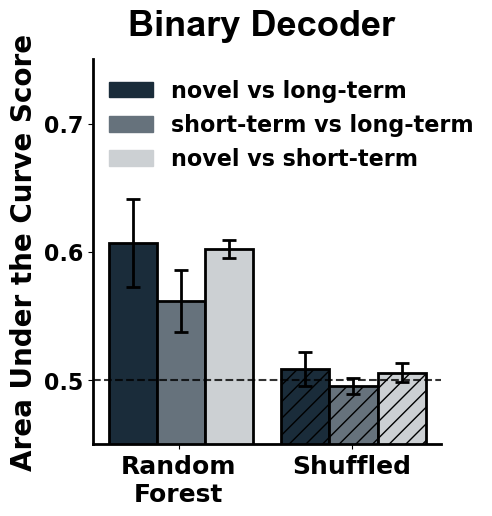

In [10]:
binary_auc_dict = unpickle_this('phase2_binary_auc.pkl')
binary_auc = binary_auc_dict['auc']
new_dict = collapsed_auc_dict(binary_auc, 0, 3, 100, 5)


pre_window = 5
equalize = 5
avg_auc = {}
i = 1
no_plots = len(new_dict.keys())
height_fig = no_plots//2
categories = ['novel vs long-term', 'short-term vs long-term', 'novel vs short-term'] # Example categories
ttests = {}
for key in new_dict.keys():
    results = {}
    for pair in combinations(categories, 2):
        t_stat, p_value = ttest_rel(new_dict[key][pair[0]],new_dict[key][pair[1]])
        results[pair] = [t_stat, p_value]
    ttests[key] = results

ttess_df = pd.DataFrame.from_dict(ttests)

print(ttess_df)
avg_values = {category: [] for category in categories}
sem_values = {category: [] for category in categories}
for key in new_dict.keys():
    for category in categories:
        avg_values[category].append(np.mean(new_dict[key][category], axis=0))
        sem_values[category].append(sem(new_dict[key][category], axis=0))

bar_width = 0.25  # Width of each bar
x = np.arange(len(list(new_dict.keys())))  # x-axis positions
legend_labels = {category: [] for category in categories}
plt.figure(figsize=(4.5, 5))
col = [ hex_2_rgb('#1a2c3a'),hex_2_rgb('#66727c'), hex_2_rgb('#ccd0d3') ]
spacing = [0, -.1]
edge = ['white', 'black','black', 'black']
for i, category in enumerate(categories):
    positions = x + (i -0.32) * bar_width  # Adjust positions for each category
    alphas = [1, 1, 1, 1]
    hatches = ['','//','','//']
    for j, pos in enumerate(positions):
        bar = plt.bar(pos + spacing[j], avg_values[category][j],
                      width=bar_width, yerr=sem_values[category][j],
                     capsize=5, edgecolor = 'black', alpha=alphas[j],
                     hatch = hatches[j], linewidth = 2, 
                    error_kw={'elinewidth': 2, 'capthick': 2},
                     label=category if i == 0 else '', color = col[i])
plt.ylim(0.45, .75)
plt.yticks(fontsize=16)
for i, color in enumerate(col):
    plt.plot([], [], color=color, label=categories[i], linewidth=5)  # Empty plots to create the legend

# Create handles for the legend (rectangles as pseudo bars)
legend_patches = [mpatches.Patch(color=col[i], label=categories[i]) for i in range(len(col))]

# Add the custom legend with rectangles as pseudo bars
legend = plt.legend(handles=legend_patches, fontsize = 16, frameon= False, bbox_to_anchor=(1.15,1.0))
legend.get_title().set_fontsize('18') 
legend.get_title().set_ha('left')
legend.get_title().set_position((-30, 1))
plt.xticks(x + spacing+0.16, new_dict.keys(), fontsize = 18)
plt.axhline(y=0.5, color='black', linestyle='--', alpha = 0.8)
plt.ylabel('Area Under the Curve Score', fontsize=20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.suptitle('Binary Decoder', fontsize = 26, font = 'Arial')
plt.subplots_adjust(hspace=0.5)
plt.savefig('phase2_binary.png', dpi = 600, transparent = True, bbox_inches='tight')

plt.show()

In [11]:

categories = ['novel vs long-term', 'short-term vs long-term', 'novel vs short-term'] # Example categories
ttests = {}
print(new_dict['Shuffled'].keys())
for key in new_dict.keys():
    ps = []
    ts = []
    order = []
    results = {}
    for pair in combinations(categories, 2):
        t_stat, p_value = mannwhitneyu(new_dict[key][pair[0]],new_dict[key][pair[1]])
        ts.append(t_stat)
        ps.append(p_value)
        order.append(pair)
    adj_p = multipletests(ps, alpha=0.05, method='holm')[1]
    print(adj_p)
    ttests[key] = {'order':order,
                             'stats': ts,
                             'p value': ps,
                             'adj p': adj_p}
                             
expanded_rows = []
for key, nested_dict in ttests.items():
        # Get the length of the lists (assuming all lists are of equal length)
    list_length = len(nested_dict['order'])
    print(list_length)
    for i in range(list_length):
        row = {
            'key': key,
            'order': nested_dict['order'][i],
            'stats': nested_dict['stats'][i],
            'p value': nested_dict['p value'][i],
            'adj p': nested_dict['adj p'][i]
        }
        expanded_rows.append(row)

# Create DataFrame from the expanded rows
new_df = pd.DataFrame(expanded_rows)

# Set MultiIndex
new_df = new_df.set_index(['key'])

new_df


dict_keys(['novel vs long-term', 'short-term vs long-term', 'novel vs short-term'])
[1.         1.         0.28571429]
[1. 1. 1.]
3
3


,order,stats,p value,adj p
key,,,,
Random\nForest,"(novel vs long-term, short-term vs long-term)",16.0,0.547619,1.000000
Random\nForest,"(novel vs long-term, novel vs short-term)",13.0,1.000000,1.000000
Random\nForest,"(short-term vs long-term, novel vs short-term)",4.0,0.095238,0.285714
Shuffled,"(novel vs long-term, short-term vs long-term)",17.0,0.420635,1.000000
Shuffled,"(novel vs long-term, novel vs short-term)",16.0,0.547619,1.000000
Shuffled,"(short-term vs long-term, novel vs short-term)",8.0,0.420635,1.000000


## Probability Plotting 

In [12]:
# [auc,prob] = decode_id_w_time_labels(equalize = 3,
#                                     pre_window = 1,
#                                     post_window = 0,
#                                     num_fold = 5,
#                                     num_shuffle = 5,
#                                     no_PCs = 12, 
#                                     events = ['cagemate', 'novel', 'recall'],
#                                     plot = True)
                                

In [13]:
# from scipy.stats import norm
# prob_dict = prob
# avg_prob = {}
# no_plots = len(prob_dict.keys())
# height_fig = math.ceil(no_plots/2)
# i = 1
# color_dict = {'exposure 1': hex_2_rgb('#001424'), 'exposure 2': hex_2_rgb('#66727c'), 'exposure 3': hex_2_rgb('#ccd0d3')}
# line_dict = {'positive': '-', 'negative':'--'}
# plt.figure(figsize=(24,4*height_fig))
# for key in prob_dict.keys():
#     plt.subplot(height_fig,3,i)
#     #average across timebins
#     glm_avg = np.mean(prob_dict[key]['glm'], axis = 1)
#     #flatten across folds
#     glm_avg = glm_avg.flatten()
#     rf_avg = np.mean(prob_dict[key]['rf'], axis = 1)
#     rf_avg = rf_avg.flatten()
#     glm_shuffle_avg = np.mean(np.mean(prob_dict[key]['glm_shuffle'], axis = 1), axis = 1)
#     glm_shuffle_avg = glm_shuffle_avg.flatten()
#     rf_shuffle_avg = np.mean(np.mean(prob_dict[key]['rf_shuffle'], axis = 1), axis = 1)
#     rf_shuffle_avg = rf_shuffle_avg.flatten()
#     labels = prob_dict[key]['time labels'].flatten()
#     id_labels = prob_dict[key]['id labels'].flatten()
#     for id_type in np.unique(id_labels):
#         line_dict = {f'{key}': '-', f'not {key}':'--'}
#         id_mask = (id_labels == id_type)
#         labels_temp = labels[id_mask]
#         rf_avg_temp = rf_avg[id_mask]
#         for label in np.unique(labels):
#             if id_type == 0.0:
#                 id_label = f'Not {key}'
#                 edgecolor_id = 'black'
#                 id_linetype = '--'
#             else:
#                 id_label = f'{key}'
#                 edgecolor_id = 'red'
#                 id_linetype = '-'
#             time_mask = (labels_temp == label)
#             rf_avg_temp_temp = rf_avg_temp[time_mask]
#             x = np.linspace(0, 1, 100)
#             p = norm.pdf(x, np.mean(rf_avg_temp_temp), np.std(rf_avg_temp_temp))
#             #plt.hist(rf_avg_temp_temp, bins=30, density=True, edgecolor=edgecolor_id, alpha=0.7, label = f'{id_label}, {label}', color = color_dict[label])
#             plt.plot(x, p, linewidth=2, linestyle = id_linetype, color = color_dict[label])
#             exposure_labels = [plt.Line2D([0], [0], color=color_dict[label], lw=2, label=label) for label in color_dict]
#             time_labels = [plt.Line2D([0], [0], linestyle=line_dict[label], color = 'k', lw=2, label=label) for label in line_dict]
#             legend_labels = exposure_labels + time_labels
#             plt.legend(handles=legend_labels, frameon= False, fontsize = 14, bbox_to_anchor=(.71, 1))
#             plt.xlabel('Probability', fontsize = 16)
#             plt.ylabel('Density', fontsize = 16)
#             plt.gca().spines['top'].set_visible(False)
#             plt.gca().spines['right'].set_visible(False)
#             plt.xticks(fontsize=14)
#             plt.yticks(fontsize=14)
#     plt.title(f'Random forest trained for {key}',fontsize = 20, y = 1.07)
#     i +=1
# plt.subplots_adjust(wspace=0.25)
# plt.show()

In [14]:
# [auc_time,prob_time] = decode_id_w_id_labels(equalize = 5,
#                                     pre_window = 5,
#                                     post_window = 0,
#                                     num_fold = 5,
#                                     num_shuffle = 5,
#                                     no_PCs = 8, 
#                                     events = ['exposure 1', 'exposure 2', 'exposure 3'],
#                                     plot = True)


In [15]:
# from scipy.stats import norm
# prob_dict = prob_time_5
# avg_prob = {}
# no_plots = len(prob_dict.keys())
# height_fig = math.ceil(no_plots/2)
# i = 1
# color_dict = {'novel': hex_2_rgb('#115566'), 'cagemate': hex_2_rgb('#792910') , 'recall': hex_2_rgb('#FFAF00')}
# spacing = [.79,.65,.65]
# plt.figure(figsize=(24,4*height_fig))
# for key in prob_dict.keys():
#     plt.subplot(height_fig,3,i)
#     #average across timebins
#     glm_avg = prob_dict[key]['glm'][:,99,:]
#     #flatten across folds
#     glm_avg = glm_avg.flatten()
#     rf_avg = np.mean(prob_dict[key]['rf'], axis = 1)
#     rf_avg = rf_avg.flatten()
#     glm_shuffle_avg = np.mean(np.mean(prob_dict[key]['glm_shuffle'], axis = 1), axis = 1)
#     glm_shuffle_avg = glm_shuffle_avg.flatten()
#     rf_shuffle_avg = np.mean(np.mean(prob_dict[key]['rf_shuffle'], axis = 1), axis = 1)
#     rf_shuffle_avg = rf_shuffle_avg.flatten()
#     labels = prob_dict[key]['id labels'].flatten()
#     id_labels = prob_dict[key]['time labels'].flatten()
#     for id_type in np.unique(id_labels):
#         id_mask = (id_labels == id_type)
#         labels_temp = labels[id_mask]
#         rf_avg_temp = rf_avg[id_mask]
#         for label in np.unique(labels):
#             line_dict = {f'{key}': '-', f'not {key}':'--'}
#             if id_type == 0.0:
#                 id_label = f'Not {key}'
#                 edgecolor_id = 'black'
#                 id_linetype = '--'
#             else:
#                 id_label = f'{key}'
#                 edgecolor_id = 'red'
#                 id_linetype = '-'
#             time_mask = (labels_temp == label)
#             rf_avg_temp_temp = rf_avg_temp[time_mask]
#             x = np.linspace(0, 1, 100)
#             p = norm.pdf(x, np.mean(rf_avg_temp_temp), np.std(rf_avg_temp_temp))
#             #plt.hist(rf_avg_temp_temp, bins=30, density=True, edgecolor=edgecolor_id, alpha=0.7, label = f'{id_label}, {label}', color = color_dict[label])
#             plt.plot(x, p, linewidth=2, linestyle = id_linetype, color = color_dict[label])
#             exposure_labels = [plt.Line2D([0], [0], color=color_dict[label], lw=2, label=label) for label in color_dict]
#             time_labels = [plt.Line2D([0], [0], linestyle=line_dict[label], color = 'k', lw=2, label=label) for label in line_dict]
#             legend_labels = exposure_labels + time_labels
#             plt.legend(handles=legend_labels, frameon= False, fontsize = 14, bbox_to_anchor=(spacing[i-1], 1.05))
#             plt.xlabel('Probability', fontsize = 16)
#             plt.ylabel('Density', fontsize = 16)
#             plt.gca().spines['top'].set_visible(False)
#             plt.gca().spines['right'].set_visible(False)
#             plt.xticks(fontsize=14)
#             plt.yticks(fontsize=14)
#     plt.title(f'Random trained for {key}', fontsize = 20, y = 1.07)
#     i +=1
# plt.subplots_adjust(wspace=0.4)
# plt.show()

## Exposure vs Agent

### Decoder Calls

In [16]:


# [auc_100, prob_100] = phase2_analysis.trial_decoder(equalize = 5,
#                                             pre_window = 3,
#                                             post_window = 0,
#                                             num_fold=5,
#                                             num_shuffle=5,
#                                             no_PCs= 20, 
#                                             events = ['novel', 'cagemate', 'recall'],
#                                             mode = 'rf')
                                            
# [auc_time_100, prob_time_100] = phase2_analysis.trial_decoder(equalize = 5,
#                                             pre_window = 3,
#                                             post_window = 0,
#                                             num_fold=5,
#                                             num_shuffle=5,
#                                             no_PCs= 19, 
#                                             events = ['exposure 1', 'exposure 2', 'exposure 3'],
#                                             mode = 'rf')

# decoder_results  = [auc_100, prob_100, auc_time_100, prob_time_100]
# pickle_this(decoder_results, 'phase2_agent_order_aucs.pkl')

### Plotting

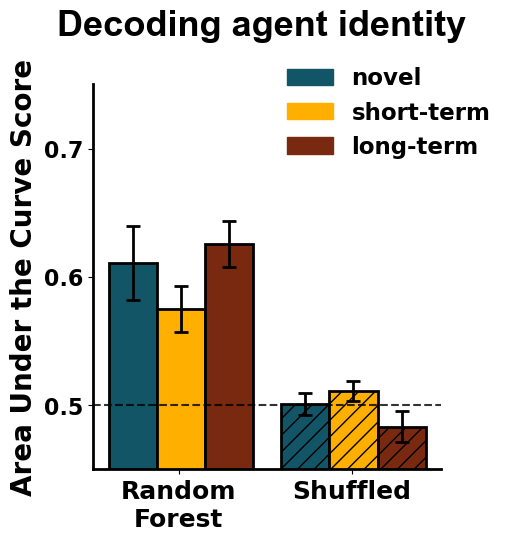

In [17]:

decoder_results = unpickle_this('phase2_agent_order_aucs.pkl')
auc_100 = decoder_results[0]
auc_time_100 = decoder_results[2]
combined_dict_100 = {**auc_100, **auc_time_100}
onehundredms_dict = collapsed_auc_dict(auc_100, 0, 3, 100, 4)
avg_auc = {}
i = 1
no_plots = len(onehundredms_dict.keys())
height_fig = no_plots//2
categories = ['novel', 'recall', 'cagemate'] # Example categories
categories_for_legend = ['novel', 'short-term', 'long-term']



avg_values = {category: [] for category in categories}
sem_values = {category: [] for category in categories}
for key in onehundredms_dict.keys():
    for category in categories:
        avg_values[category].append(np.mean(onehundredms_dict[key][category], axis=0))
        sem_values[category].append(sem(onehundredms_dict[key][category], axis=0))

bar_width = 0.25  # Width of each bar
x = np.arange(len(list(onehundredms_dict.keys())))  # x-axis positions
legend_labels = {category: [] for category in categories}
plt.figure(figsize=(4.5, 5))
col = [hex_2_rgb('#115566'), hex_2_rgb('#FFAF00'), hex_2_rgb('#792910') ]
spacing = [0, -0.1]
edge = ['black','black', 'black', 'black', 'black', 'black']
for i, category in enumerate(categories):
    positions = x + (i -0.32) * bar_width  # Adjust positions for each category
    alphas = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    hatches = ['','//','','//', '', '//', '', '//', '', '//']
    for j, pos in enumerate(positions):
        bar = plt.bar(pos + spacing[j], avg_values[category][j], width=bar_width, yerr=sem_values[category][j],
                capsize=5, 
                linewidth = 2, 
                error_kw={'elinewidth': 2, 'capthick': 2},edgecolor=edge[i], alpha=alphas[j], label=category if i == 0 else '', color = col[i], hatch=hatches[j])
plt.ylim(0.45, .75)
plt.yticks(fontsize=16)
for i, color in enumerate(col):
    plt.plot([], [], color=color, label=categories[i], linewidth=5)  # Empty plots to create the legend
# Create handles for the legend (rectangles as pseudo bars)
legend_patches = [mpatches.Patch(color=col[i], label=categories_for_legend[i]) for i in range(len(col))]
# Add the custom legend with rectangles as pseudo bars
legend = plt.legend(handles=legend_patches, fontsize = 16.5, frameon= False, bbox_to_anchor=(1.2,1.1))
#title = '                                           Trained on >99% variance')
legend.get_title().set_fontsize('18') 
legend.get_title().set_ha('left')
#legend.get_title().set_position((-105, 1))
plt.xticks(x + spacing+0.16, onehundredms_dict.keys(), fontsize = 18)
plt.axhline(y=0.5, color='black', linestyle='--', alpha = 0.8)
plt.ylabel('Area Under the Curve Score', fontsize=20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))

plt.suptitle('Decoding agent identity', fontsize = 26, font = 'Arial', y = 1.03)
plt.subplots_adjust(hspace=0.5)
plt.savefig('phase2_decoder.png', dpi = 600, transparent = True, bbox_inches='tight')

plt.show()

### Stats

In [20]:
onehundredms_dict

ttests = {}
for key in onehundredms_dict.keys():
    order_order = []
    agent_order = []
    order_ps = []
    agent_ps = []
    order_stats = []
    agent_stats = []
    for pair in combinations(categories, 2):
        if ('exposure' in pair[0]) and ('exposure' in pair[1]):
            order_t_stat, order_p_value = mannwhitneyu(onehundredms_dict[key][pair[0]],onehundredms_dict[key][pair[1]])
            order_order.append(pair)
            order_ps.append(order_p_value)
            order_stats.append(order_t_stat)
        if ('exposure' not in pair[0]) and ('exposure' not in pair[1]):
            agent_t_stat, agent_p_value = mannwhitneyu(onehundredms_dict[key][pair[0]],onehundredms_dict[key][pair[1]])
            agent_order.append(pair)
            agent_ps.append(agent_p_value)
            agent_stats.append(agent_t_stat)
            print(pair)
    agent_adj_p = multipletests(agent_ps, alpha=0.05, method='holm')[1]
    #order_adj_p = multipletests(order_ps, alpha=0.05, method='holm')[1]
    ttests[key] = {'agent': {'order':agent_order,
                             'stats': agent_stats,
                             'p value': agent_ps,
                             'adj p': agent_adj_p}}

expanded_rows = []

# Iterate through the nested dictionary
for key, nested_dict in ttests.items():
    for subkey, metrics in nested_dict.items():
        # Get the length of the lists (assuming all lists are of equal length)
        list_length = len(metrics['order'])
        for i in range(list_length):
            row = {
                'key': key,
                'type': subkey,
                'order': metrics['order'][i],
                'stats': metrics['stats'][i],
                'p value': metrics['p value'][i],
                'adj p': metrics['adj p'][i]
            }
            expanded_rows.append(row)

# Create DataFrame from the expanded rows
df = pd.DataFrame(expanded_rows)

# Set MultiIndex
df = df.set_index(['key', 'type'])

df

('novel', 'recall')
('novel', 'cagemate')
('recall', 'cagemate')
('novel', 'recall')
('novel', 'cagemate')
('recall', 'cagemate')


order  stats   p value     adj p
key            type                                                
Random\nForest agent     (novel, recall)   18.0  0.309524  0.619048
               agent   (novel, cagemate)   14.0  0.841270  0.841270
               agent  (recall, cagemate)    4.0  0.095238  0.285714
Shuffled       agent     (novel, recall)    7.0  0.309524  0.666667
               agent   (novel, cagemate)   18.0  0.309524  0.666667
               agent  (recall, cagemate)   19.0  0.222222  0.666667